# Exploratory Data Analysis: Finland Electricity Imbalance Prices

This notebook explores the Fingrid API data used for predicting electricity imbalance prices in Finland.

**Datasets:**
- Wind Power Generation (MW) - Dataset 181
- mFRR Activation Price (EUR/MWh) - Dataset 342
- Imbalance Price (EUR/MWh) - Dataset 319 (target variable)

In [1]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Project imports - using pipeline module for data loading
from pipeline.features import read_dlt_table
from ingestion.processor import (
    merge_datasets, resample_to_15min,
    create_lag_features, create_rolling_features, create_temporal_features
)

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Check if Azure connection is available
AZURE_AVAILABLE = bool(os.getenv('AZURE_STORAGE_CONNECTION_STRING'))
print(f"Azure Storage: {'Connected' if AZURE_AVAILABLE else 'Not configured (using local data)'}")
print('Imports loaded successfully!')

Imports loaded successfully!


## 1. Load Raw Data

In [16]:
# Load raw datasets from DLT output (Azure Blob or local)
# Note: Run `python -m pipeline.ingest` first if data doesn't exist

wind_df = read_dlt_table('wind_power')
mfrr_df = read_dlt_table('mfrr_activation')
price_df = read_dlt_table('imbalance_price')

print(f"Wind Power:      {len(wind_df):,} rows, {wind_df['timestamp'].min()} to {wind_df['timestamp'].max()}")
print(f"mFRR Activation: {len(mfrr_df):,} rows, {mfrr_df['timestamp'].min()} to {mfrr_df['timestamp'].max()}")
print(f"Imbalance Price: {len(price_df):,} rows, {price_df['timestamp'].min()} to {price_df['timestamp'].max()}")

Wind Power:      174,953 rows, 2025-01-01 00:00:00+00:00 to 2025-12-31 23:57:00+00:00
mFRR Activation: 31,770 rows, 2025-01-01 00:00:00+00:00 to 2025-12-31 23:45:00+00:00
Imbalance Price: 29,613 rows, 2025-01-01 00:00:00+00:00 to 2025-12-31 23:45:00+00:00


## 2. Data Quality Overview

In [4]:
def data_quality_report(df, name, value_col):
    """Generate data quality summary."""
    print(f"\n{'='*50}")
    print(f"{name} Data Quality Report")
    print(f"{'='*50}")
    print(f"Shape: {df.shape}")
    print("\nMissing values:")
    print(df.isnull().sum())
    print(f"\n{value_col} Statistics:")
    print(df[value_col].describe())
    return df[value_col].describe()

wind_stats = data_quality_report(wind_df, "Wind Power", "wind_power_mw")
mfrr_stats = data_quality_report(mfrr_df, "mFRR Activation", "mfrr_price")
price_stats = data_quality_report(price_df, "Imbalance Price", "imbalance_price")


Wind Power Data Quality Report
Shape: (14872, 2)

Missing values:
timestamp        0
wind_power_mw    0
dtype: int64

wind_power_mw Statistics:
count    14872.000000
mean      2868.652646
std       1969.084220
min         58.998000
25%       1038.375000
50%       2528.000000
75%       4566.250000
max       6601.000000
Name: wind_power_mw, dtype: float64

mFRR Activation Data Quality Report
Shape: (1026, 2)

Missing values:
timestamp     0
mfrr_price    0
dtype: int64

mfrr_price Statistics:
count    1026.000000
mean      -23.644250
std       160.625932
min      -783.000000
25%       -44.750000
50%         0.000000
75%         9.000000
max       703.000000
Name: mfrr_price, dtype: float64

Imbalance Price Data Quality Report
Shape: (744, 2)

Missing values:
timestamp          0
imbalance_price    0
dtype: int64

imbalance_price Statistics:
count    744.000000
mean      58.642151
std       81.801005
min      -93.910000
25%        0.500000
50%       26.030000
75%       93.490000
max     

## 3. Target Variable Distribution (Imbalance Price)

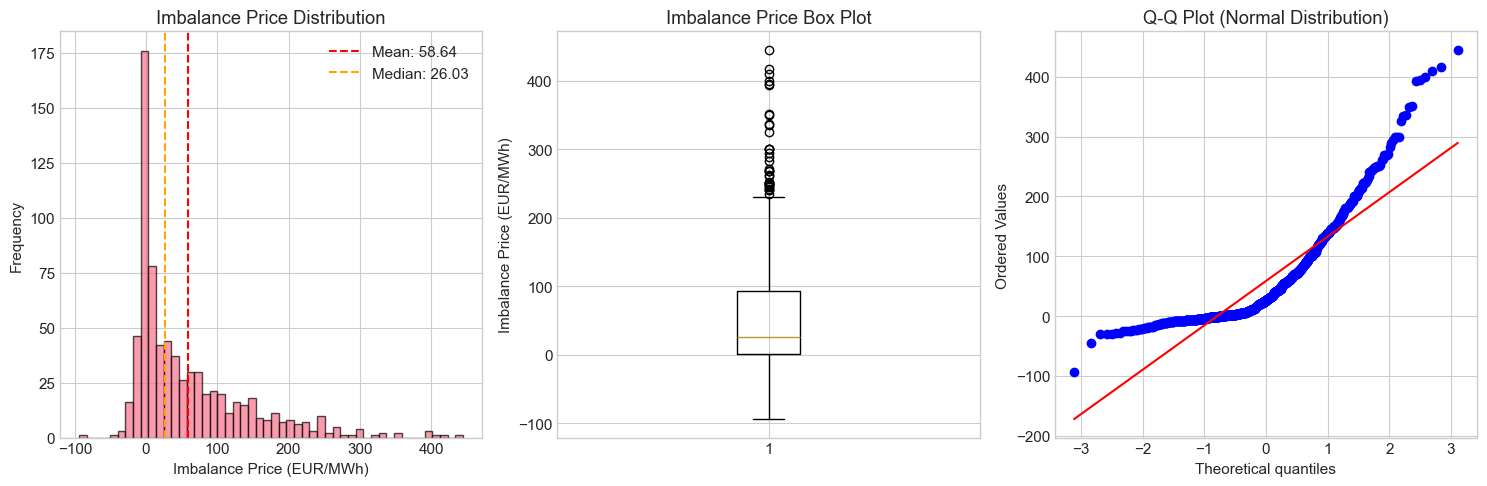


Skewness: 1.664
Kurtosis: 2.964


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
axes[0].hist(price_df['imbalance_price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(price_df['imbalance_price'].mean(), color='red', linestyle='--', label=f"Mean: {price_df['imbalance_price'].mean():.2f}")
axes[0].axvline(price_df['imbalance_price'].median(), color='orange', linestyle='--', label=f"Median: {price_df['imbalance_price'].median():.2f}")
axes[0].set_xlabel('Imbalance Price (EUR/MWh)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Imbalance Price Distribution')
axes[0].legend()

# Box plot
axes[1].boxplot(price_df['imbalance_price'].dropna(), vert=True)
axes[1].set_ylabel('Imbalance Price (EUR/MWh)')
axes[1].set_title('Imbalance Price Box Plot')

# Q-Q plot
from scipy import stats
stats.probplot(price_df['imbalance_price'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normal Distribution)')

plt.tight_layout()
plt.savefig('../reports/eda/price_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSkewness: {price_df['imbalance_price'].skew():.3f}")
print(f"Kurtosis: {price_df['imbalance_price'].kurtosis():.3f}")

## 4. Time Series Visualization

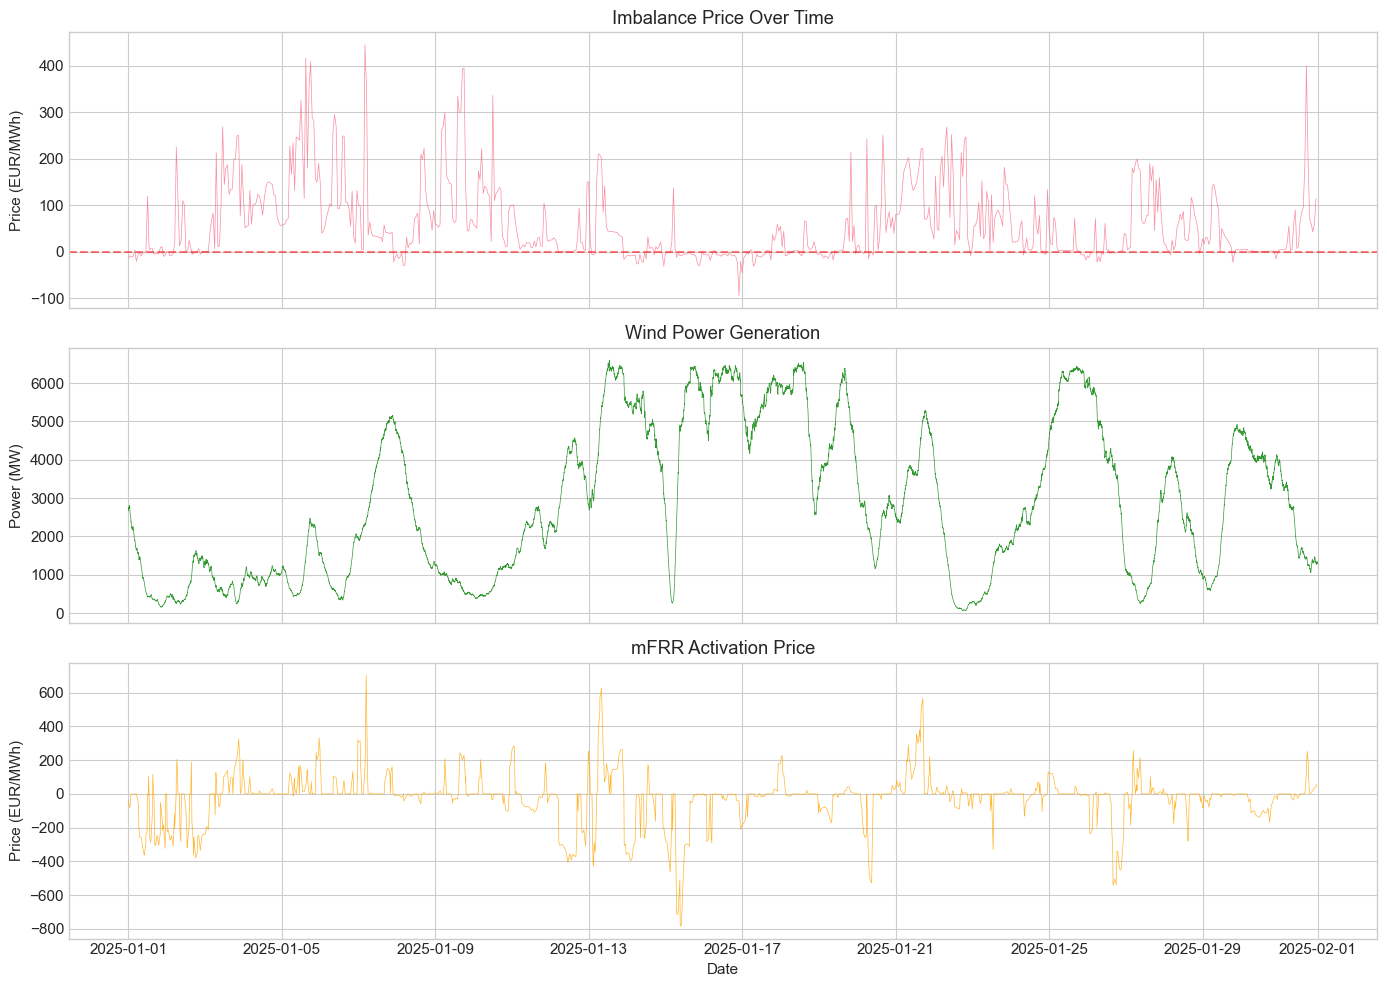

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Price
axes[0].plot(price_df['timestamp'], price_df['imbalance_price'], linewidth=0.5, alpha=0.8)
axes[0].set_ylabel('Price (EUR/MWh)')
axes[0].set_title('Imbalance Price Over Time')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)

# Wind
axes[1].plot(wind_df['timestamp'], wind_df['wind_power_mw'], linewidth=0.5, alpha=0.8, color='green')
axes[1].set_ylabel('Power (MW)')
axes[1].set_title('Wind Power Generation')

# mFRR
axes[2].plot(mfrr_df['timestamp'], mfrr_df['mfrr_price'], linewidth=0.5, alpha=0.8, color='orange')
axes[2].set_ylabel('Price (EUR/MWh)')
axes[2].set_title('mFRR Activation Price')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.savefig('../reports/eda/time_series_overview.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Temporal Patterns

Data range: 2025-01-01 to 2025-12-31
Unique months: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]


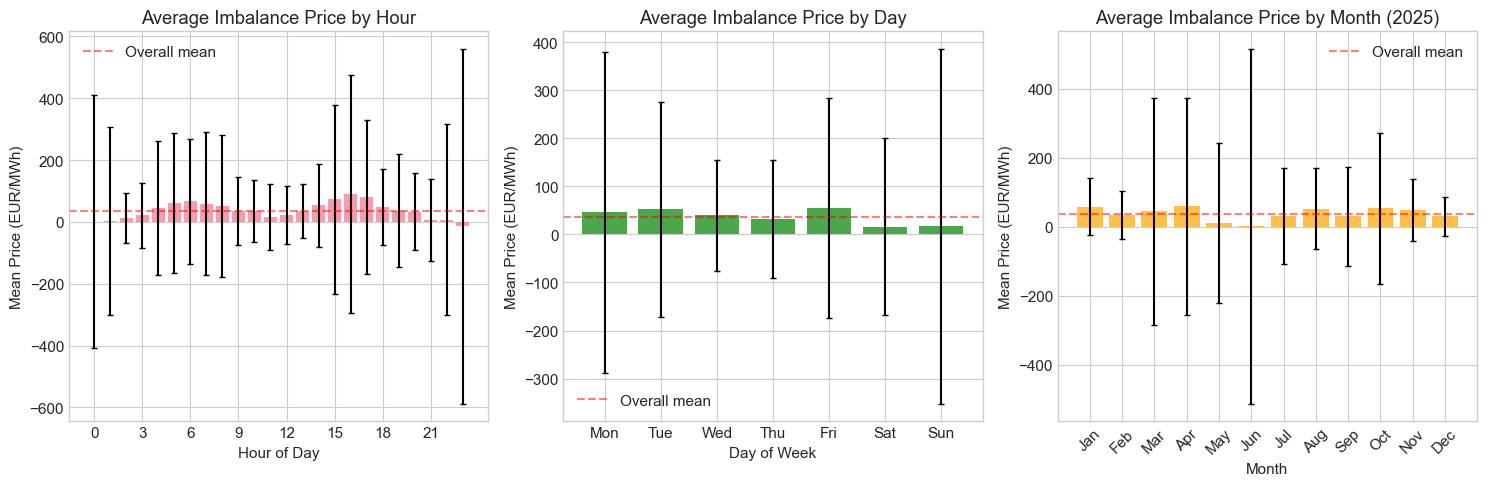

In [17]:
# Add temporal features for analysis
price_df['hour'] = price_df['timestamp'].dt.hour
price_df['dayofweek'] = price_df['timestamp'].dt.dayofweek
price_df['month'] = price_df['timestamp'].dt.month
price_df['day'] = price_df['timestamp'].dt.day

# Check date range
date_min, date_max = price_df['timestamp'].min(), price_df['timestamp'].max()
unique_months = sorted(price_df['month'].unique())
print(f"Data range: {date_min.strftime('%Y-%m-%d')} to {date_max.strftime('%Y-%m-%d')}")
print(f"Unique months: {unique_months}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Hourly pattern
hourly = price_df.groupby('hour')['imbalance_price'].agg(['mean', 'std'])
axes[0].bar(hourly.index, hourly['mean'], yerr=hourly['std'], capsize=2, alpha=0.7)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Mean Price (EUR/MWh)')
axes[0].set_title('Average Imbalance Price by Hour')
axes[0].set_xticks(range(0, 24, 3))
axes[0].axhline(y=hourly['mean'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall mean')
axes[0].legend()

# Day of week pattern
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily = price_df.groupby('dayofweek')['imbalance_price'].agg(['mean', 'std'])
axes[1].bar(range(7), daily['mean'], yerr=daily['std'], capsize=2, alpha=0.7, color='green')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Mean Price (EUR/MWh)')
axes[1].set_title('Average Imbalance Price by Day')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days)
axes[1].axhline(y=daily['mean'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall mean')
axes[1].legend()

# Monthly pattern (full year data)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly = price_df.groupby('month')['imbalance_price'].agg(['mean', 'std'])
axes[2].bar(monthly.index, monthly['mean'], yerr=monthly['std'], capsize=2, alpha=0.7, color='orange')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Mean Price (EUR/MWh)')
axes[2].set_title('Average Imbalance Price by Month (2025)')
axes[2].set_xticks(monthly.index)
axes[2].set_xticklabels([month_names[m-1] for m in monthly.index], rotation=45)
axes[2].axhline(y=monthly['mean'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall mean')
axes[2].legend()

plt.tight_layout()
plt.savefig('../reports/eda/temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Correlation Analysis

Merged dataset: 2,973 rows


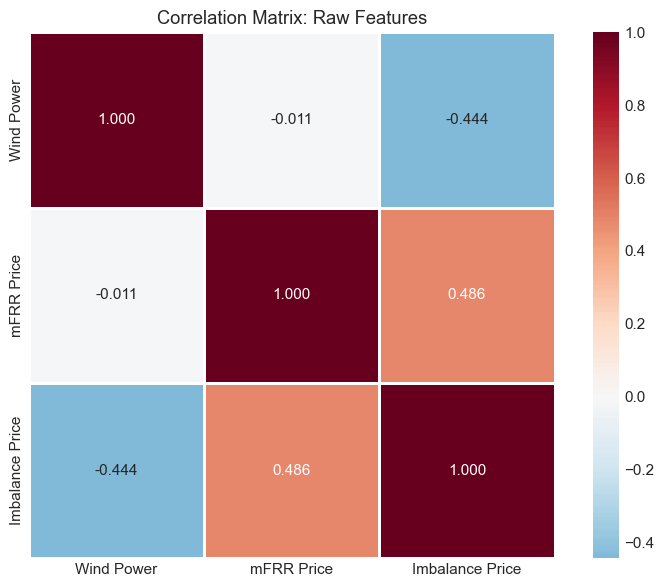

In [ ]:
# Resample and merge for correlation analysis
wind_15m = resample_to_15min(wind_df, 'wind_power_mw', method='mean')
mfrr_15m = resample_to_15min(mfrr_df, 'mfrr_price', method='ffill')
price_15m = resample_to_15min(price_df[['timestamp', 'imbalance_price']], 'imbalance_price', method='ffill')

merged = merge_datasets(wind_15m, mfrr_15m, price_15m)
print(f"Merged dataset: {len(merged):,} rows")

# Correlation matrix
corr_cols = ['wind_power_mw', 'mfrr_price', 'imbalance_price']
corr_matrix = merged[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=1, fmt='.3f',
            xticklabels=['Wind Power', 'mFRR Price', 'Imbalance Price'],
            yticklabels=['Wind Power', 'mFRR Price', 'Imbalance Price'])
plt.title('Correlation Matrix: Raw Features')
plt.tight_layout()
plt.savefig('../reports/eda/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Scatter Plots: Feature Relationships

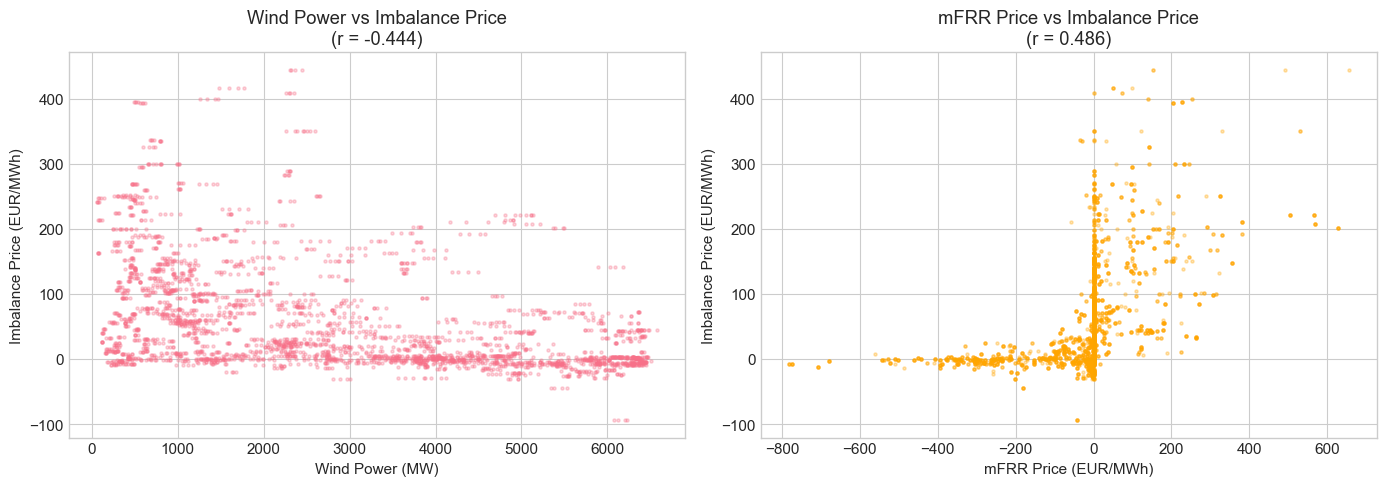

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wind vs Price
axes[0].scatter(merged['wind_power_mw'], merged['imbalance_price'], alpha=0.3, s=5)
axes[0].set_xlabel('Wind Power (MW)')
axes[0].set_ylabel('Imbalance Price (EUR/MWh)')
axes[0].set_title(f'Wind Power vs Imbalance Price\n(r = {merged["wind_power_mw"].corr(merged["imbalance_price"]):.3f})')

# mFRR vs Price
axes[1].scatter(merged['mfrr_price'], merged['imbalance_price'], alpha=0.3, s=5, color='orange')
axes[1].set_xlabel('mFRR Price (EUR/MWh)')
axes[1].set_ylabel('Imbalance Price (EUR/MWh)')
axes[1].set_title(f'mFRR Price vs Imbalance Price\n(r = {merged["mfrr_price"].corr(merged["imbalance_price"]):.3f})')

plt.tight_layout()
plt.savefig('../reports/eda/scatter_relationships.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Feature Engineering Analysis

In [10]:
# Create features using processor functions
features_df = create_lag_features(merged)
features_df = create_rolling_features(features_df)
features_df = create_temporal_features(features_df)
features_df = features_df.dropna()

print(f"Processed features: {len(features_df):,} rows, {len(features_df.columns)} columns")
print("\nFeature columns:")
for i, col in enumerate(features_df.columns):
    print(f"  {i+1:2d}. {col}")


🔧 Creating features...
  ✓ Lag features (1h, 2h, 3h, 6h, 12h, 24h + momentum)
  ✓ Rolling statistics (mean, std, min/max)
  ✓ Temporal features (hour, day, month + cyclical encoding)

🧹 Dropped 96 rows with NaN (from lag/rolling)
  Final dataset: 2,877 rows with 44 features
Processed features: 2,877 rows, 44 columns

Feature columns:
   1. timestamp
   2. wind_power_mw
   3. mfrr_price
   4. imbalance_price
   5. price_lag_1h
   6. price_lag_2h
   7. price_lag_3h
   8. price_lag_6h
   9. price_lag_12h
  10. price_lag_24h
  11. wind_lag_1h
  12. wind_lag_2h
  13. wind_lag_6h
  14. wind_lag_24h
  15. mfrr_lag_1h
  16. mfrr_lag_3h
  17. price_change_1h
  18. price_change_3h
  19. price_rolling_1h
  20. price_rolling_3h
  21. price_rolling_6h
  22. price_rolling_24h
  23. wind_rolling_1h
  24. wind_rolling_3h
  25. wind_rolling_6h
  26. price_volatility_3h
  27. price_volatility_6h
  28. wind_volatility_3h
  29. price_min_6h
  30. price_max_6h
  31. price_range_6h
  32. hour_of_day
  33. 

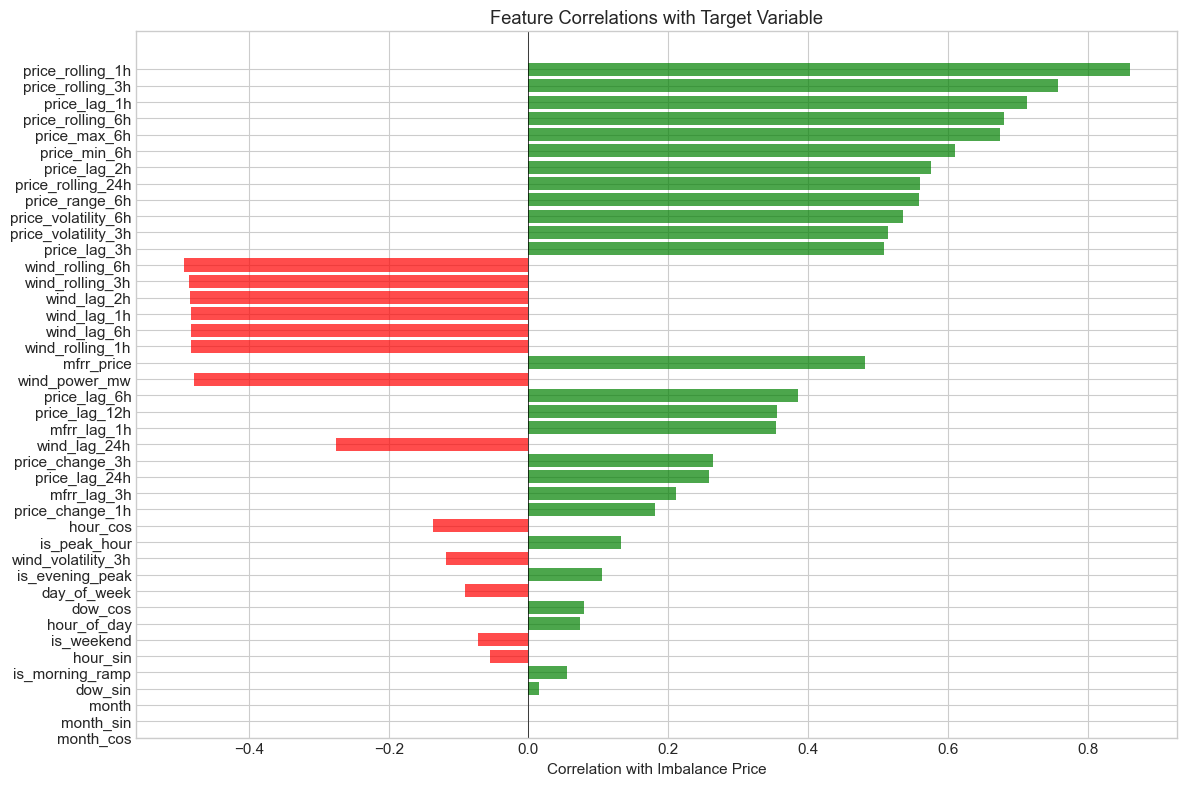


Top 10 most correlated features:
price_rolling_1h       0.859869
price_rolling_3h       0.756923
price_lag_1h           0.712693
price_rolling_6h       0.680447
price_max_6h           0.673805
price_min_6h           0.609611
price_lag_2h           0.575463
price_rolling_24h      0.559570
price_range_6h         0.559198
price_volatility_6h    0.536233


In [ ]:
# Correlation with target for all features
target = 'imbalance_price'
feature_cols = [c for c in features_df.columns if c not in ['timestamp', target]]

correlations = features_df[feature_cols + [target]].corr()[target].drop(target).sort_values(key=abs, ascending=False)

plt.figure(figsize=(12, 8))
colors = ['green' if c > 0 else 'red' for c in correlations.values]
plt.barh(range(len(correlations)), correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(correlations)), correlations.index)
plt.xlabel('Correlation with Imbalance Price')
plt.title('Feature Correlations with Target Variable')
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/eda/feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 most correlated features:")
print(correlations.head(10).to_string())

## 9. Price Volatility Analysis

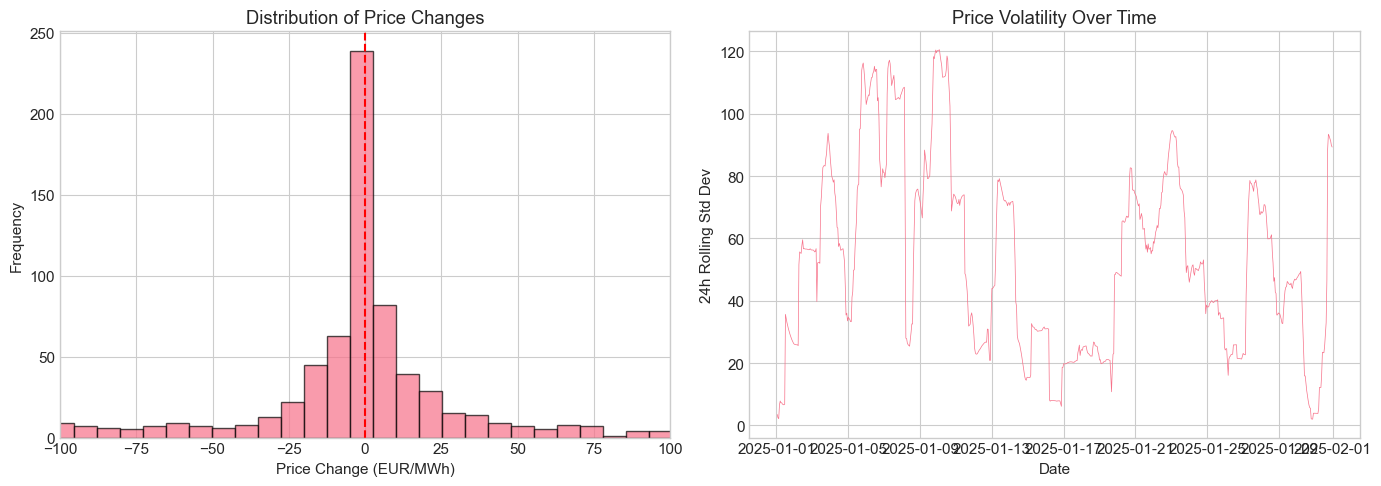


Price change statistics:
  Mean change: 0.17 EUR/MWh
  Std dev: 61.79 EUR/MWh
  Max increase: 439.55 EUR/MWh
  Max decrease: -313.86 EUR/MWh


In [ ]:
# Calculate price changes
price_df['price_change'] = price_df['imbalance_price'].diff()
price_df['price_change_pct'] = price_df['imbalance_price'].pct_change() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of price changes
axes[0].hist(price_df['price_change'].dropna(), bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlabel('Price Change (EUR/MWh)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Price Changes')
axes[0].set_xlim(-100, 100)  # Focus on main distribution

# Rolling volatility
rolling_vol = price_df.set_index('timestamp')['imbalance_price'].rolling('24h').std()
axes[1].plot(rolling_vol.index, rolling_vol.values, linewidth=0.5)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('24h Rolling Std Dev')
axes[1].set_title('Price Volatility Over Time')

plt.tight_layout()
plt.savefig('../reports/eda/volatility_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPrice change statistics:")
print(f"  Mean change: {price_df['price_change'].mean():.2f} EUR/MWh")
print(f"  Std dev: {price_df['price_change'].std():.2f} EUR/MWh")
print(f"  Max increase: {price_df['price_change'].max():.2f} EUR/MWh")
print(f"  Max decrease: {price_df['price_change'].min():.2f} EUR/MWh")

## 10. Key Insights Summary

In [13]:
print("="*60)
print("KEY INSIGHTS FROM EDA")
print("="*60)

print("\n📊 DATA OVERVIEW:")
print(f"   - Time range: {price_df['timestamp'].min()} to {price_df['timestamp'].max()}")
print(f"   - Total observations: {len(price_df):,}")

print("\n💰 TARGET VARIABLE (Imbalance Price):")
print(f"   - Mean: {price_df['imbalance_price'].mean():.2f} EUR/MWh")
print(f"   - Median: {price_df['imbalance_price'].median():.2f} EUR/MWh")
print(f"   - Std Dev: {price_df['imbalance_price'].std():.2f} EUR/MWh")
print(f"   - Range: [{price_df['imbalance_price'].min():.2f}, {price_df['imbalance_price'].max():.2f}]")
print(f"   - Skewness: {price_df['imbalance_price'].skew():.3f}")

print("\n🔗 CORRELATIONS:")
print(f"   - Wind Power ↔ Price: {merged['wind_power_mw'].corr(merged['imbalance_price']):.3f}")
print(f"   - mFRR Price ↔ Price: {merged['mfrr_price'].corr(merged['imbalance_price']):.3f}")

print("\n⏰ TEMPORAL PATTERNS:")
print(f"   - Highest avg price hour: {hourly['mean'].idxmax()}:00 ({hourly['mean'].max():.2f} EUR/MWh)")
print(f"   - Lowest avg price hour: {hourly['mean'].idxmin()}:00 ({hourly['mean'].min():.2f} EUR/MWh)")

print("\n🎯 TOP PREDICTIVE FEATURES:")
for i, (feat, corr) in enumerate(correlations.head(5).items(), 1):
    print(f"   {i}. {feat}: {corr:.3f}")

print("\n" + "="*60)

KEY INSIGHTS FROM EDA

📊 DATA OVERVIEW:
   - Time range: 2025-01-01 00:00:00+00:00 to 2025-01-31 23:00:00+00:00
   - Total observations: 744

💰 TARGET VARIABLE (Imbalance Price):
   - Mean: 58.64 EUR/MWh
   - Median: 26.03 EUR/MWh
   - Std Dev: 81.80 EUR/MWh
   - Range: [-93.91, 444.90]
   - Skewness: 1.664

🔗 CORRELATIONS:
   - Wind Power ↔ Price: -0.444
   - mFRR Price ↔ Price: 0.486

⏰ TEMPORAL PATTERNS:
   - Highest avg price hour: 17:00 (101.62 EUR/MWh)
   - Lowest avg price hour: 2:00 (20.09 EUR/MWh)

🎯 TOP PREDICTIVE FEATURES:
   1. price_rolling_1h: 0.860
   2. price_rolling_3h: 0.757
   3. price_lag_1h: 0.713
   4. price_rolling_6h: 0.680
   5. price_max_6h: 0.674

